In [1438]:
import torch
import numpy as np

In [1453]:
class HousingDataset(Dataset):    
    def __init__(self, df):
        self.dataframe = df
    
    def standard_scale(self, df):
        scaler = StandardScaler()
        scaler.fit(df)
        data = scaler.transform(df)
        data = pd.DataFrame(data, columns = df.columns)
        return data
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = np.asarray(self.dataframe.iloc[idx])
        x = torch.tensor(sample[:-1])
        label = torch.tensor(sample[-1])
            
        return x.float(), label.float()
        

In [1465]:
from torch.utils.data import Dataset, DataLoader

def get_data(df, batch_size):
    torch.manual_seed(0)
    
    scaler = StandardScaler()
    scaler.fit(df)
    data = scaler.transform(df)
    data = pd.DataFrame(data, columns = df.columns)

    split_idx = int(len(data)*0.9)

    train_data = data[:split_idx]
    test_data = data[split_idx:]

    train_dataset = HousingDataset(train_data)
    test_dataset = HousingDataset(test_data)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    
    test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset),
                            shuffle=True, num_workers=0)
    
    return train_dataloader, test_dataloader

In [1466]:
def train_net(net, train_dataloader, lr = 0.001, n_epochs = 30, loss_criterion = nn.MSELoss()):

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    epoch_losses = torch.zeros(n_epochs)
    iteration_losses = []
    
    best_loss = None
    
    epochs_since_improvement = 0

    for epoch in range(n_epochs):
        if epochs_since_improvement == 3:
            print(f'Model stopped converging at epoch {epoch}, Loss: {loss}')
            break
        
        for i_batch, sample_batched in enumerate(train_dataloader):
            x, y = sample_batched
            
            y = torch.reshape(y, (y.shape[0],1))
            predictions = net(x)

            loss = loss_criterion(predictions, y)  
            
            if best_loss == None:
                best_loss = loss.item()
                
            iteration_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            if loss.item() < best_loss:
                best_loss == loss.item()
                # Sparar ner parametrarna som gett det hittils minsta loss.
                torch.save(net.state_dict(), 'best_model.pt')
                
        epoch_losses[epoch] = loss
        
        if (epoch+1) % 10 == 0 and epoch != 0:
            print(f'Epoch {epoch+1} / {n_epochs} Train loss: {loss}')
        
        if loss >= best_loss:
            epochs_since_improvement += 1

    return epoch_losses, iteration_losses


In [1469]:
df = pd.read_csv('../data/housing.csv', header=None, delimiter=r"\s+", names= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])

train_dataloader, test_dataloader = get_data(df, batch_size = 8)

print(f'Train DataLoader:\nLength: {len(train_dataloader.dataset)}\nBatchsize: {train_dataloader.batch_size}\n-')
print(f'Test DataLoader:\nLength: {len(test_dataloader.dataset)}\nBatchsize: {test_dataloader.batch_size}\n{"-"*10}')

net = nn.Sequential(nn.Linear(13,32), nn.ReLU(),
                    nn.Linear(32,16), nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(16,1)).float()

losses, iteration_losses = train_net(net, 
                                     train_dataloader, 
                                     lr = 0.001, 
                                     n_epochs = 30, 
                                     loss_criterion = nn.MSELoss())


Train DataLoader:
Length: 455
Batchsize: 8
-
Test DataLoader:
Length: 51
Batchsize: 51
----------
Epoch 10 / 30 Train loss: 0.07768422365188599
Epoch 20 / 30 Train loss: 0.10307382792234421
Epoch 30 / 30 Train loss: 0.14812703430652618


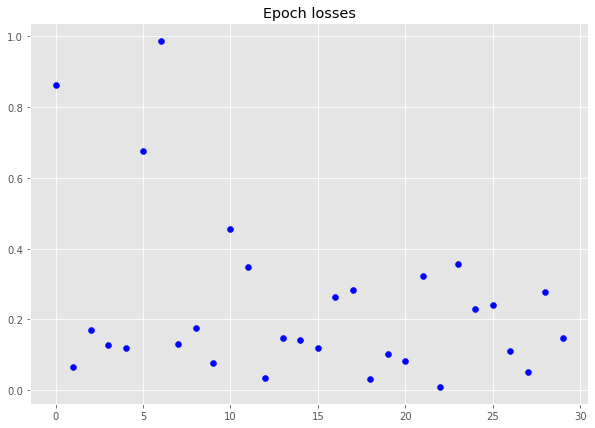

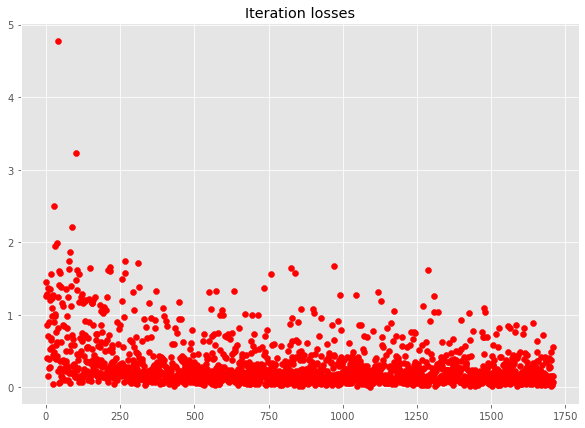

In [1470]:
plt.figure(figsize = (10,7))
plt.scatter([i for i in range(len(losses))], [tensor.item() for tensor in losses], c = 'Blue')
plt.title('Epoch losses')
plt.show()

plt.figure(figsize = (10,7))
plt.scatter([i for i in range(len(iteration_losses))], list(iteration_losses), c = 'Red')
plt.title('Iteration losses')
plt.show()


In [1491]:
def load_model(path):
    # Här sätter vi ett tomt nät med samma arkitektur som vi sedan laddar med dem sparade parametrarna
    model = nn.Sequential(nn.Linear(13,32), nn.ReLU(),
                        nn.Linear(32,16), nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(16,1)).float()
    
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [1492]:
model = load_model('best_model.pt')

In [1493]:
for _, batch in enumerate(test_dataloader):
    x, y = batch

    y = torch.reshape(y, (y.shape[0],1))
    predictions = net(x)

y = [t.item() for t in y]
predictions = [t.item() for t in predictions]

R2:  0.04703414731456068
MSE:  0.21357172035388097
MAE:  0.3311806528591642
MAPE:  1.495777929824436


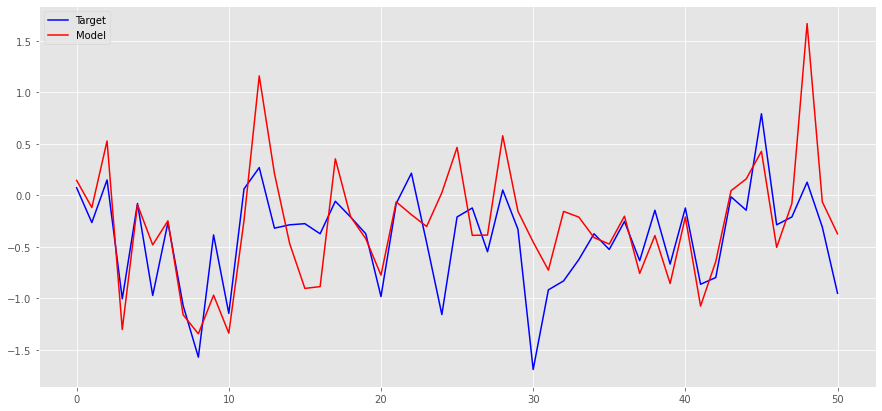

In [1494]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

r2_score = r2(y, predictions)
mse_score = mse(y, predictions)
mae_score = mae(y, predictions)
mape_score = mape(y, predictions)

print('R2: ', r2_score)
print('MSE: ', mse_score)
print('MAE: ', mae_score)
print('MAPE: ', mape_score)

plt.figure(figsize = (15,7))
plt.plot([i for i in range(len(predictions))], y, c = 'blue', label = 'Target')
plt.plot([i for i in range(len(predictions))], predictions, c = 'red', label = 'Model')
plt.legend()

plt.show()

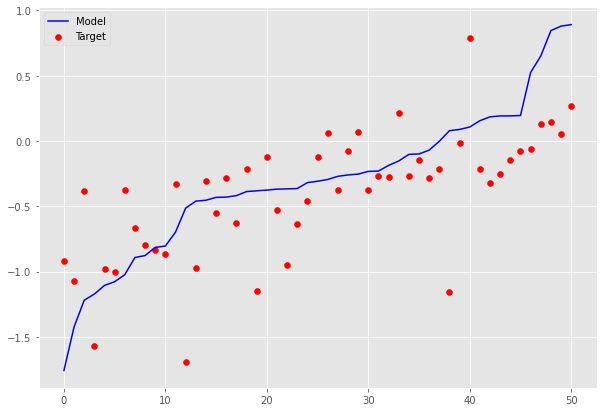

In [1495]:
zipped = list(zip(y, predictions))
sorted_ = list(sorted(l, key = lambda x: x[1]))

plt.figure(figsize = (10,7))
plt.scatter([i for i in range(len(s))],[i[0] for i in sorted_], label = 'Target', c = 'Red')
plt.plot([i for i in range(len(s))],[i[1] for i in sorted_], label = 'Model', c = 'Blue')
plt.legend()
plt.show()